In [14]:
import csv
import os
import tweepy
import pandas as pd
import re
import json
import emoji
import pickle
import random
import numpy as np
from textblob import TextBlob
import nltk
import time
from langdetect import detect
nltk.download('punkt')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix
import gensim
nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import TfidfVectorizer


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yifan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\yifan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [106]:
## Cleaning methods
def clean_emoji(text):
    text=emoji.demojize(text)
    return text

def remove_url(text):
    text = ' '.join(re.sub("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"," ", text).split())
    return text


def remove_symbol(text):
    text = str.replace(text,',',' ')
    text = str.replace(text,'+',' ')
    text = str.replace(text,'=',' ')
    text = ' '.join(re.sub("(\d{3}[-\.\s]??\d{3}[-\.\s]??\d{4}|\(\d{3}\)\s*\d{3}[-\.\s]??\d{4}|\d{3}[-\.\s]??\d{4})"," ", text).split())
    text = str.replace(text,"'",' ')
    text = str.replace(text,'"',' ')
    text = str.replace(text,'!',' ')
    text = str.replace(text,'^',' ')
    text = str.replace(text,'(',' ')
    text = str.replace(text,')',' ')
    text = str.replace(text,'%',' ')
    text = str.replace(text,'-',' ')
    text = str.replace(text,'_',' ')
    text = str.replace(text,'|',' ')
    text = str.replace(text,'.',' ')
    text = str.replace(text,':',' ')
    return text
    
## this is the optional function we can use to remove @ and other. Might not use it if we need to analyze retweets
def optional_rm(text):
    all_words = text.split(' ')
    remove_words = []
    for each in all_words:
        if each == ' ' or each == '':
            continue
        if each[0] == '#' or each[0] == '@':
            remove_words.append(each)
    for word in remove_words:
        all_words.remove(word)
    text = ' '.join(all_words)
    
    text = text.split(' ')
    new_text = []
    for each in text:
        if(str.find(each,'http') != -1):
            continue
        
        if not each.isalnum():
            continue
        new_text.append(str.lower(each));
    text = ' '.join(new_text)
    
    return text
    
def is_english(text):
    try:
        if detect(text) == "en":
            return True
        else:
            return False
    except Exception as e:
        return True
        print(e)
    
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

    
def processing(text):
    text=clean_emoji(text)
    text=remove_url(text)
    text = remove_symbol(text)
    text = optional_rm(text)
    return text

In [3]:
## Import Data
def read_json_to_dataframe(filename):
    f = open(filename,encoding = 'utf-16').read()
    f1 = pd.read_json(f, orient='records',lines=True)
    return f1

In [16]:
df=read_json_to_dataframe('F:/USC/Fall 20/ISE_540/10-21-2020.json')
## expand the place column into many cols
def expand_col(df):
    place_df = df['tweet_place'].apply(pd.Series)
    place_df.columns = ["place_id", "place_url", "place_type","place_name", "place_full_name", "place_country_code", "place_country","place_bouding_box", "place_attribute"]
    ## expand tweet_geo column into many cols
    geo_df = df['tweet_geo'].apply(pd.Series)
    lat_long_df = geo_df["coordinates"].apply(pd.Series)
    lat_long_df.columns = ["lat", "long"]
    df = pd.concat([df.drop(["tweet_place", "tweet_geo"], axis = 1), place_df, lat_long_df], axis = 1)
    return df
df = expand_col(df)
# df[df["lat"].notna()]

hashtags og_tweet_id og_tweet_time og_tweet_txt og_tweet_user_desc  \
125                                  NaT                                   
7178                                 NaT                                   
12734                                NaT                                   
21971                                NaT                                   
43827                                NaT                                   
57737                                NaT                                   

      og_tweet_user_id og_tweet_user_loc og_tweet_user_name  \
125                                                           
7178                                                          
12734                                                         
21971                                                         
43827                                                         
57737                                                         

      og_tweet_user_vrifd             tweet_id  ...  \
125                        1318810013633146880  ...   
7178                       1318893681219227649  ...   
12734                      1318933386698887169  ...   
21971                      1318969314276528129  ...   
43827                      1319013513810108419  ...   
57737                      1319144335514816512  ...   

                                               place_url place_type  \
125    https://api.twitter.com/1.1/geo/id/791e00bcadc...       city   
7178   https://api.twitter.com/1.1/geo/id/457b4814b42...       city   
12734  https://api.twitter.com/1.1/geo/id/dd9c0d7d7e0...    country   
21971  https://api.twitter.com/1.1/geo/id/535f0c2de01...       city   
43827  https://api.twitter.com/1.1/geo/id/33ad9818da3...       city   
57737  https://api.twitter.com/1.1/geo/id/457b4814b42...       city   

         place_name    place_full_name place_country_code   place_country  \
125         Glasgow  Glasgow, Scotland                 GB  United Kingdom   
7178         London    London, England                 GB  United Kingdom   
12734  South Africa       South Africa                 ZA    South Africa   
21971      Warszawa   Warszawa, Polska                 PL          Polska   
43827      Waterloo  Waterloo, Ontario                 CA          Canada   
57737        London    London, England                 GB  United Kingdom   

                                       place_bouding_box place_attribute  \
125    {'type': 'Polygon', 'coordinates': [[[-4.39328...              {}   
7178   {'type': 'Polygon', 'coordinates': [[[-0.18789...              {}   
12734  {'type': 'Polygon', 'coordinates': [[[16.44759...              {}   
21971  {'type': 'Polygon', 'coordinates': [[[20.85255...              {}   
43827  {'type': 'Polygon', 'coordinates': [[[-80.6261...              {}   
57737  {'type': 'Polygon', 'coordinates': [[[-0.18789...              {}   

             lat       long  
125    55.891897  -4.289824  
7178   51.504136  -0.136089  
12734 -25.152600  28.853100  
21971  52.232222  21.008333  
43827  43.460868 -80.529424  
57737  51.505390  -0.124860  

[6 rows x 32 columns]

In [18]:
# copy = df.copy()
# copy["tweet_txt"] = copy["tweet_txt"].apply(clean_emoji)
# copy["tweet_txt"] = copy["tweet_txt"].apply(remove_symbol)
# a = copy[copy["tweet_txt"].apply(is_english)]
# a.shape

(63059, 32)

In [20]:
## Split the data into two parts, one for original tweet txt, another one for tweet txt
## drop na 
## remove the row which tweet_txt has no full text
def split_data(dataframe):
    df_og=dataframe[['og_tweet_txt', 'og_tweet_time', 'og_tweet_id', 'og_tweet_user_id',
       'og_tweet_user_name', 'og_tweet_user_desc', 'og_tweet_user_vrifd',
       'og_tweet_user_loc']]
    df_tweet=dataframe[['tweet_txt', 'user_loc', 'tweet_geo',
       'tweet_place', 'tweet_time', 'tweet_id', 'user_id', 'user_name',
       'tweet_likes', 'tweet_source', 'hashtags', 'user_acc_cr_time',
       'user_verified', 'user_total_tweets', 'user_followers']]
    dt_og=df_og.copy()
    dt_og=dt_og.dropna(axis=0,how='any')
    dt_og=dt_og[~dt_og['og_tweet_txt'].isin(['\u2026'])]  
    dt_tweet=df_tweet.copy()
    # dt_tweet=dt_tweet.dropna(axis=0,how='any')
    dt_tweet=dt_tweet[~dt_tweet['tweet_txt'].str.contains('\u2026')]
    
    
    ## text cleaning
#     dt_og['tweet_txt_clean']=dt_og['og_tweet_txt'].apply(lambda x: processing(x))
#     dt_tweet['tweet_txt_clean']=dt_tweet['tweet_txt'].apply(lambda x: processing(x))
    
#     dt_og = dt_og[dt_og["tweet_txt_clean"].apply(is_english)]
#     dt_tweet = dt_tweet[dt_tweet["tweet_txt_clean"].apply(is_english)]
    
    return dt_og, dt_tweet

In [6]:
# df1,df2=split_data(df)

In [7]:
# pd.set_option('display.max_colwidth', -1)

In [12]:
## TextBlob & Vader
def textblob_vader(split_dataframe):
    split_dataframe['groupcount']=1
    df=split_dataframe.groupby('tweet_txt_clean').sum().sort_values(by=['groupcount'],ascending=False)
    df=df.reset_index()
    word_list=df.values.tolist()
    with open('textblob_vader_all_tweets.csv','a',newline='') as datacsv:
        writer =csv.writer(datacsv)
        writer.writerow(['count','tweet_txt','textblob_score','vader_score'])
        sid = SentimentIntensityAnalyzer()
        for i in range(len(word_list)):
            count=word_list[i][1] 
            blob=TextBlob(word_list[i][0])  #error: should be str not class<'float'>
            textblob_senti=blob.sentiment.polarity
            vader_senti=sid.polarity_scores(word_list[i][0])
            data=[[count,blob,str(textblob_senti),vader_senti]]
            for item in data:
                writer.writerow(item)

In [13]:
# textblob_vader(df1)

In [15]:
def main():
    path = '/Users/Xiilz./Desktop/540 Project'
    files = os.listdir(path)
    for i in files:
        if 'json' in i:
            data = read_json_to_dataframe(i)
            dataset1,dataset2=split_data(data)            
            textblob_vader(dataset1)
            textblob_vader(dataset2)     

In [ ]:
main() 

## Create sample set for manual label

In [26]:
def read_in(path):
    files = os.listdir(path)
    all_dfs = []
    print(files)
    for i in files:
        if 'json' in i:
            each_df = read_json_to_dataframe(path+i)
            all_dfs.append(each_df)
            
    return pd.concat(all_dfs, ignore_index=True)

all_df = read_in('F:/USC/Fall 20/ISE_540/project_data/')
all_df.shape
            
#             dataset1,dataset2=split_data(data)            
#             textblob_vader(dataset1)
#             textblob_vader(dataset2)   

['10-19-2020.json', '10-20-2020.json', '10-21-2020.json', '10-22-2020.json', '10-23-2020.json', '10-24-2020.json', '10-25-2020.json']


(371940, 23)

In [110]:
all_df.shape

(371940, 23)

In [97]:
## Get rid of the folded tweets
test_df = all_df.copy()
test_df=test_df[~test_df['og_tweet_txt'].str.endswith('\u2026',na=True)]
test_df=test_df[~((test_df['tweet_txt'].str.endswith('\u2026',na=True)) & (test_df['og_tweet_txt'].str.strip() == ""))]
# test_df=test_df.dropna(axis=0,how='any')
test_df

hashtags          og_tweet_id       og_tweet_time  \
1                                                               NaT   
2                                                               NaT   
3                           1318171846651596807 2020-10-19 12:47:13   
4                           1318171846651596807 2020-10-19 12:47:13   
5                                                               NaT   
6                           1318169264789049344 2020-10-19 12:36:57   
7                           1318211343862943744 2020-10-19 15:24:10   
8                           1318170245178142721 2020-10-19 12:40:51   
10                          1318158518512472065 2020-10-19 11:54:15   
11        TarHeelsTogether  1318230752635637761 2020-10-19 16:41:17   
13                          1317295512727527424 2020-10-17 02:44:59   
14                          1318052089197715456 2020-10-19 04:51:20   
15                          1318258160868667403 2020-10-19 18:30:12   
16                          1318280098588536833 2020-10-19 19:57:22   
17                          1318284547335835648 2020-10-19 20:15:03   
18                          1318280998627512321 2020-10-19 20:00:57   
19                                                              NaT   
20      Hydroxychloroquine  1318278112841523200 2020-10-19 19:49:29   
21                          1318280998627512321 2020-10-19 20:00:57   
22                                                              NaT   
23                          1318280098588536833 2020-10-19 19:57:22   
24                                                              NaT   
25                          1318105805304995842 2020-10-19 08:24:47   
26                                                              NaT   
27                          1318280098588536833 2020-10-19 19:57:22   
28                          1318280098588536833 2020-10-19 19:57:22   
29                          1316793416236306433 2020-10-15 17:29:49   
30                          1318211343862943744 2020-10-19 15:24:10   
31                          1318284547335835648 2020-10-19 20:15:03   
32                                                              NaT   
...                    ...                  ...                 ...   
371910                      1320263104702353408 2020-10-25 07:17:08   
371911                                                          NaT   
371912         Coronavirus                                      NaT   
371913         Coronavirus                                      NaT   
371914                                                          NaT   
371915                                                          NaT   
371916                      1320248190533275653 2020-10-25 06:17:52   
371917                      1319728194606538752 2020-10-23 19:51:35   
371918                      1320008949677150208 2020-10-24 14:27:12   
371919                                                          NaT   
371920                                                          NaT   
371921                      1319900487240515584 2020-10-24 07:16:13   
371922           Patanjali  1275322937906610178 2020-06-23 07:00:57   
371923                      1319109310215942145 2020-10-22 02:52:22   
371924                      1320065854197944320 2020-10-24 18:13:19   
371925   LekkiMassacre2020  1319957663162224640 2020-10-24 11:03:25   
371926                      1320139861165285381 2020-10-24 23:07:24   
371927                                                          NaT   
371928                      1320257347785281536 2020-10-25 06:54:15   
371929                      1319983503145078785 2020-10-24 12:46:05   
371930                      1320266518496759810 2020-10-25 07:30:42   
371931               COVID  1320080186751258628 2020-10-24 19:10:17   
371932                      1320266518496759810 2020-10-25 07:30:42   
371933                                                          NaT   
371934                                    

In [98]:
def clean_txt(df):
    df["og_tweet_txt"] = df['og_tweet_txt'].apply(lambda x: processing(x))
    df['tweet_txt'] = df['tweet_txt'].apply(lambda x: processing(x))
    df[df["tweet_txt"].apply(is_english)]
    df[df["og_tweet_txt"].apply(is_english)]
    return df

In [107]:
clean_df = clean_txt(test_df)

In [155]:
clean_df.iloc[28]["og_tweet_txt"]

'rt watch trump says he won t force americans to take covid 19 vaccine'

In [112]:
clean_df.to_pickle("./cleaned.pkl")

In [7]:
with open("./cleaned.pkl", 'rb') as f:
    clean_df = pickle.load(f)

In [8]:
clean_df.columns

Index(['hashtags', 'og_tweet_id', 'og_tweet_time', 'og_tweet_txt',
       'og_tweet_user_desc', 'og_tweet_user_id', 'og_tweet_user_loc',
       'og_tweet_user_name', 'og_tweet_user_vrifd', 'tweet_geo', 'tweet_id',
       'tweet_likes', 'tweet_place', 'tweet_source', 'tweet_time', 'tweet_txt',
       'user_acc_cr_time', 'user_followers', 'user_id', 'user_loc',
       'user_name', 'user_total_tweets', 'user_verified'],
      dtype='object')

In [9]:
clean_df["combined_tweet_txt"] = clean_df["tweet_txt"] + clean_df["og_tweet_txt"]
clean_df.columns

Index(['hashtags', 'og_tweet_id', 'og_tweet_time', 'og_tweet_txt',
       'og_tweet_user_desc', 'og_tweet_user_id', 'og_tweet_user_loc',
       'og_tweet_user_name', 'og_tweet_user_vrifd', 'tweet_geo', 'tweet_id',
       'tweet_likes', 'tweet_place', 'tweet_source', 'tweet_time', 'tweet_txt',
       'user_acc_cr_time', 'user_followers', 'user_id', 'user_loc',
       'user_name', 'user_total_tweets', 'user_verified',
       'combined_tweet_txt'],
      dtype='object')

## See the accuracy rate of the off-the-shelf sentiment analysis

In [304]:
## pkl read in the df here to save time

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
sentiment_df = pd.read_csv("./full_tweet_sample.csv")
list_of_txt = list(sentiment_df["full_text"])
true_sent = list(sentiment_df["sentiment"])
sid = SentimentIntensityAnalyzer()
sent_copy = true_sent.copy()

In [11]:
def thresh_choosing(thresh, method):
    textblob_vader = []
#     vader_list = []
    for each_tweet in list_of_txt:
        blob=TextBlob(each_tweet)  #error: should be str not class<'float'>
        textblob_senti=blob.sentiment.polarity
        vader_senti=sid.polarity_scores(each_tweet)
        if method == "vader":
            textblob_vader.append(vader_senti['compound'])
        elif method == "textblob":
            textblob_vader.append(textblob_senti)
        
    #     data=[blob,textblob_senti,vader_senti['compound']]
    # accuracy_score(true_sent, textblob_list)
    sent_copy = true_sent.copy()
    for counter, value in enumerate(sent_copy):
        if value>=thresh:
            sent_copy[counter] = 1
        else:
            sent_copy[counter] = -1

    for counter, value in enumerate(textblob_vader):
        if value >= thresh:
            textblob_vader[counter] = 1
        elif value < thresh:
            textblob_vader[counter] = -1
    labels = np.unique(sent_copy)
    a = confusion_matrix(sent_copy, textblob_vader, labels = labels)
    conf = pd.DataFrame(a, index=labels, columns=labels)
    return f1_score(sent_copy, textblob_vader), conf
#     return accuracy_score(sent_copy, textblob_vader), confusion_matrix(sent_copy, textblob_vader)

In [12]:
def bi_thresh_choosing(low, high):
    textblob_list = []
    vader_list = []
    for each_tweet in list_of_txt:
        blob=TextBlob(each_tweet)  #error: should be str not class<'float'>
        textblob_senti=blob.sentiment.polarity
        vader_senti=sid.polarity_scores(each_tweet)
        textblob_list.append(textblob_senti)
        vader_list.append(vader_senti['compound'])
    #     data=[blob,textblob_senti,vader_senti['compound']]
    # accuracy_score(true_sent, textblob_list)
    sent_copy = true_sent.copy()
#     for counter, value in enumerate(sent_copy):
#         if value>=thresh:
#             sent_copy[counter] = 1

    for counter, value in enumerate(textblob_list):
        if value >= high:
            textblob_list[counter] = 1
        elif value <= low:
            textblob_list[counter] = -1
        elif value < high and value > low:
            textblob_list[counter] = 0
    labels = np.unique(sent_copy)
    a = confusion_matrix(sent_copy, textblob_list, labels = labels)
    conf = pd.DataFrame(a, index=labels, columns=labels)
    return f1_score(sent_copy, textblob_list, average = "weighted"), conf

In [15]:
threshold = np.arange(-0.99, 0.99, 0.01)
low_thresh = np.arange(-0.9, 0.9, 0.1)
# high_thresh = np.arrange(0.99, 0.0, 0.01)
# threshold

## bi-thresh calc:

textblob

In [22]:
labels = np.unique(sent_copy)
thresh_choosing(-0.8,"textblob")[1]

-1    1
-1   0  222
 1   1  777

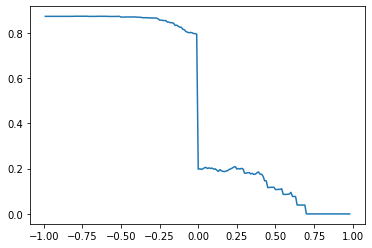

In [303]:
import matplotlib.pyplot as plt
ac_list_1 = []
for thresh in threshold:
    ac_list_1.append(thresh_choosing(thresh,"textblob")[0])

print(plt.plot(threshold, ac_list_1))

In [245]:
ac_list_1

[(0.8726042841037204, array([[  0, 225],
         [  1, 774]], dtype=int64)), (0.8726042841037204, array([[  0, 225],
         [  1, 774]], dtype=int64)), (0.8726042841037204, array([[  0, 225],
         [  1, 774]], dtype=int64)), (0.8726042841037204, array([[  0, 225],
         [  1, 774]], dtype=int64)), (0.8726042841037204, array([[  0, 225],
         [  1, 774]], dtype=int64)), (0.8726042841037204, array([[  0, 225],
         [  1, 774]], dtype=int64)), (0.8726042841037204, array([[  0, 225],
         [  1, 774]], dtype=int64)), (0.8726042841037204, array([[  0, 225],
         [  1, 774]], dtype=int64)), (0.8726042841037204, array([[  0, 225],
         [  1, 774]], dtype=int64)), (0.8726042841037204, array([[  0, 225],
         [  1, 774]], dtype=int64)), (0.8726042841037204, array([[  0, 225],
         [  1, 774]], dtype=int64)), (0.8726042841037204, array([[  0, 225],
         [  1, 774]], dtype=int64)), (0.8726042841037204, array([[  0, 225],
         [  1, 774]], dtype=int64))

In [264]:
print("The max F1 is when the binary threshold is at", threshold[ac_list_1.index(max(ac_list_1))], ", with F1 of", max(ac_list_1))
print("from")

The max F1 is when the binary threshold is at -0.7999999999999998 , with F1 of 0.8730964467005076


For Vader Method:

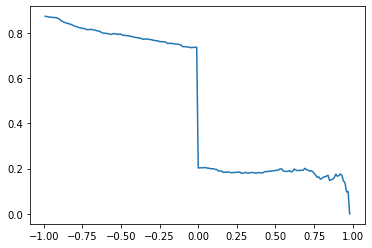

In [268]:
import matplotlib.pyplot as plt
ac_list = []
for thresh in threshold:
    ac_list.append(thresh_choosing(thresh,"vader")[0])

print(plt.plot(threshold, ac_list))

In [297]:
# labels = np.unique(sent_copy)
thresh_choosing(0,"vader")[1]

-1    1
-1  113  112
 1  259  516

## tri-tresh calc:

In [291]:
ac_list = []
thresh_list = []
for low in low_thresh:
    if low == 0.98:
        continue
    else:
        high_thresh = np.arange(low+0.1, 0.9, 0.1)
    for high in high_thresh:
        thresh_list.append({low, high})
        ac_list.append(bi_thresh_choosing(low, high)[0])
    
print(max(ac_list))

0.5799418688667549


In [292]:
thresh_list[ac_list.index(max(ac_list))]

{-0.30000000000000016, 0.5999999999999999}

In [293]:
a = bi_thresh_choosing(-0.3, 0.6)[1]
prec = a.iloc()

-1    0   1
-1  13  209   3
 0  21  648  19
 1   2   80   5

In [298]:
print("It seems like the accuracy for the negative comment is too low")

It seems like the accuracy for the negative comment is too low


## Use supervised learning


In [358]:
file_list = ["./sample_again.csv","./full_tweet_sample.csv"]
li = []
senti_df1 = pd.read_csv("./sample_again.csv")
senti_df1 = senti_df1[["full_txt", "sentiment"]]
senti_df2 = pd.read_csv("./full_tweet_sample.csv")
senti_df2 = senti_df2[["full_text", "sentiment"]]
senti_df2.columns = ["full_txt", "sentiment"]

df = pd.concat([senti_df1,senti_df2], axis=0, ignore_index=True)
X = df["full_txt"].tolist()
y = df["sentiment"].tolist()
tokens = [nltk.word_tokenize(sentences) for sentences in X]
# list_of_txt = list(sentiment_df["full_text"])
# true_sent = list(sentiment_df["sentiment"])
# sid = SentimentIntensityAnalyzer()

## Embedding Trial

In [125]:
model = gensim.models.Word2Vec(tokens, min_count=1, size=10)
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

C:\Users\yifan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  


In [126]:
model.wv.similarity("rice","biden")

0.96031535

In [127]:
model = TfidfVectorizer()
model.fit(X)
tf_idf_dict = dict(zip(model.get_feature_names(), list(model.idf_)))

In [128]:
len(tf_idf_dict)

5752

In [65]:
documents = []
for count,tweet in enumerate(X):
    word_vectors = []
    for word in tokens[count]: # or your logic for separating tokens
        sent_vec = np.zeros(10)
        if word in tf_idf_dict:
            tf_idf_score = tf_idf_dict[word]
            sent_vec += w2v[word]*tf_idf_score
            word_vectors.append(sent_vec)
    documents.append(np.concatenate(word_vectors))
documents

[array([ 1.17992916e+01, -4.72239733e+00, -2.33380818e+00,  4.28093576e+00,
         9.88577271e+00, -5.98520184e+00, -8.97886276e+00, -2.76808763e+00,
        -2.72172308e+00,  1.21859837e+00,  5.23985481e+00, -2.05231333e+00,
        -1.37754202e+00,  1.84825933e+00,  4.58235359e+00, -2.74015450e+00,
        -3.57212448e+00, -1.27112758e+00, -1.00817013e+00,  2.17849106e-01,
         1.35017538e+00, -2.43992060e-01, -4.40300882e-01,  5.61627507e-01,
         1.11349404e+00, -1.00825155e+00, -1.00728393e+00, -4.32428807e-01,
        -6.20782329e-03, -1.91429853e-01,  6.84727335e+00, -2.92513418e+00,
        -1.70371878e+00,  2.18371987e+00,  5.23884010e+00, -3.82657647e+00,
        -5.25633526e+00, -1.45039761e+00, -1.45582688e+00,  9.74596202e-01,
         1.02370157e+01, -3.95847106e+00, -2.24830961e+00,  3.44838619e+00,
         8.49080467e+00, -5.19964552e+00, -7.73412991e+00, -2.47722864e+00,
        -2.24200368e+00,  7.22718477e-01,  9.02087402e+00, -3.34096813e+00,
        -1.9

In [66]:
# class TfidfEmbeddingVectorizer(object):
#     def __init__(self, word2vec):
#         self.word2vec = word2vec
#         self.word2weight = None
#         self.dim = len(word2vec.itervalues().next())

#     def fit(self, X, y):
#         tfidf = TfidfVectorizer(analyzer=lambda x: x)
#         tfidf.fit(X)
#         # if a word was never seen - it must be at least as infrequent
#         # as any of the known words - so the default idf is the max of 
#         # known idf's
#         max_idf = max(tfidf.idf_)
#         self.word2weight = defaultdict(lambda: max_idf, [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

#         return self

#     def transform(self, X):
#         return np.array([np.mean([self.word2vec[w] * self.word2weight[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0) for words in X])

## Generate a set for now for Topic Modeling

In [67]:
json_df = all_df.sample(frac = 0.2)
json_df[:5]

NameError: name 'all_df' is not defined

In [ ]:
txt_list = json_df[["og_tweet_txt","tweet_txt"]].to_dict('records')

In [ ]:
with open("./sample.json", "w", encoding = "utf-16") as f:
    for each in txt_list:
        json.dump(each,f)
        f.write('\n')


## LSTM Trial

In [315]:
import csv
import nltk
nltk.download('stopwords')
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import random
import keras
# import keras_metrics
# STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yifan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [316]:
STOPWORDS = set(stopwords.words('english'))

In [131]:
X

['that brazilian agency did not say whether the person had received the vaccine or a placebo a',
 'evidently covid without vaccine is almost as virulent as flu with vaccine for under 70s indiscriminate interventions for an entirely discriminate pathogen doesn t make any sense even before you factor in the considerable collateral damagert evidently covid without vaccine is almost as virulent as flu with vaccine for under 70s indiscriminate',
 'dr levine now offering details on vaccine plan says the state has been planning for the arrival of a vaccine',
 'you may get free covid vaccine',
 'parents you are killing your children with vaccines wake up',
 'a new understanding of the neuropilin 1 protein may speed up covid vaccine research',
 'south korea at least 25 dead following flu vaccinations south korea sticks to flu vaccine plan despite safety',
 'if you wanna see trump supporters disagree with trump ask them to take the covid vaccine',
 'small georgia pharmacies are scrambling to fin

In [289]:
random.seed(9)

In [318]:
## clean stopwords
special_word = ['rt','co','amp']
no_stop_X = []
for each in X:
    for word in STOPWORDS:
        token = ' ' + word + ' '
        each = each.replace(token, ' ')
        for spw in special_word:
            each = each.replace(spw, '')
        each = each.strip()
    no_stop_X.append(each)

In [317]:
special_word = ['rt','co','amp']
# no_stop_X = []
def clean_stop(each):
    for word in STOPWORDS:
        token = ' ' + word + ' '
        each = each.replace(token, ' ')
        for spw in special_word:
            each = each.replace(spw, '')
        each = each.strip()
    return each
clean_df["combined_tweet_txt"] = clean_df["combined_tweet_txt"].apply(lambda x: clean_stop(x))


KeyboardInterrupt: 

In [319]:
clean_df["combined_tweet_txt"][:5]

1    long term problems younger low risk vid 19 flu...
2    new theme park vid 19 guidelines ming tomorrow...
3    must remain locked vaccine people cannot trust...
4    must remain locked vaccine people cannot trust...
5    regardless vaccine wearing mask still ntinue e...
Name: combined_tweet_txt, dtype: object

In [478]:
##split into train/test set
def split_set(no_stop_X, y):
    y_len = len(y)
    ratio = 0.8
    train_1_num = np.floor(y.count(1)*ratio)
    train_1_indices = [i for i, k in enumerate(y) if k == 1]
    train_neg_1_num = np.floor(y.count(-1)*ratio)
    train_neg_1_indices = [i for i, k in enumerate(y) if k == -1]
    train_0_num = np.floor(y.count(0)*ratio)
    train_0_indices = [i for i, k in enumerate(y) if k == 0]
    # random.selct
    train_1_set = random.sample(train_1_indices, int(train_1_num))
    train_neg_1_set = random.sample(train_neg_1_indices, int(train_neg_1_num))
    train_0_set = random.sample(train_0_indices, int(train_0_num))
    test_1_set = [i for i in train_1_indices if i not in train_1_set]
    test_neg_1_set = [i for i in train_neg_1_indices if i not in train_neg_1_set]
    test_0_set = [i for i in train_0_indices if i not in train_0_set]
    train_index = train_1_set + train_neg_1_set + train_0_set
    test_index = test_1_set + test_neg_1_set + test_0_set
    train_x = [no_stop_X[i] for i in train_index]
    train_y = [y[i] for i in train_index]
    test_x = [no_stop_X[i] for i in test_index]
    test_y = [y[i] for i in test_index]
#     print(train_y)
    return train_x, train_y, test_x, test_y

In [381]:
len(no_stop_X)

2000

In [470]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 5000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 40
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
# clean_df["combined_tweet_txt"]
tokenizer.fit_on_texts(no_stop_X)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 5485 unique tokens.


In [471]:
X_total = tokenizer.texts_to_sequences(no_stop_X)
X_total = pad_sequences(X_total, maxlen=MAX_SEQUENCE_LENGTH)

In [413]:
max_list = []
# no_stop_X[0]
for each in no_stop_X:
    max_list.append(len(each.split()))
max(max_list)

85

In [477]:
## tokenize train x and y:
def tokenize(train_x,train_y, test_x, test_y, tokenizer):
    X_train_tokenize = tokenizer.texts_to_sequences(train_x)
    X_train_tokenize = pad_sequences(X_train_tokenize, maxlen=MAX_SEQUENCE_LENGTH)
    X_test_tokenize = tokenizer.texts_to_sequences(test_x)
    X_test_tokenize = pad_sequences(X_test_tokenize, maxlen=MAX_SEQUENCE_LENGTH)
    print('Shape of data tensor:', X_train_tokenize.shape)
    y_train_dummy = pd.get_dummies(train_y).values
    y_test_dummy = pd.get_dummies(test_y).values
    print('Shape of label tensor:', y_train_dummy.shape)
    return X_train_tokenize, y_train_dummy, X_test_tokenize, y_test_dummy

In [476]:
def lstm(MAX_NB_WORDS, EMBEDDING_DIM, X_train_tokenize, y_train_dummy, X_total):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_total.shape[1]))
    model.add(tf.keras.layers.SpatialDropout1D(0.2))
    model.add(tf.keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(tf.keras.layers.Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[keras.metrics.Precision(), keras.metrics.Recall()])

    epochs = 6
    batch_size = 64

    history = model.fit(X_train_tokenize, y_train_dummy, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
    return model

In [361]:
accr = model.evaluate(X_test_tokenize,y_test_dummy)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f} Recall: {:0.3f}'.format(accr[0],accr[1],accr[2]))

13/13 [==============================] - 0s 35ms/step - loss: 0.4479 - precision_201: 0.7803 - recall_201: 0.6695
Test set
  Loss: 0.448
  Accuracy: 0.780 Recall: 0.669


In [369]:
dummy_dict = pd.get_dummies(train_y)
dummy_dict[:5]

-1   0   1
0   0   0   1
1   0   0   1
2   0   0   1
3   0   0   1
4   0   0   1

In [473]:
def confusion(model,X_test_tokenize):
    labels = [-1, 0, 1]
    predictions = model.predict(X_test_tokenize)
    final_pred = [labels[np.argmax(pred)] for pred in predictions]
    a = confusion_matrix(test_y, final_pred, labels = labels)
    conf = pd.DataFrame(a, index=labels, columns=labels)
    recall = conf.loc[-1,-1]/(conf.loc[-1,-1] + conf.loc[-1,0] + conf.loc[-1,1])
    pres = conf.loc[-1,-1]/(conf.loc[-1,-1] + conf.loc[0,-1] + conf.loc[1,-1])
    f1 = 2*(recall*pres)/(recall+pres)
    return recall, pres, conf, f1
# predictions

In [ ]:
from statistics import mean
cycle = range(5)
recall_list = []
pres_list = []
f1_list = []

for each in cycle:
    train_x, train_y, test_x, test_y = split_set(no_stop_X, y)
    X_train_tokenize, y_train_dummy, X_test_tokenize, y_test_dummy = tokenize(train_x,train_y, test_x, test_y, tokenizer)
    model = lstm(MAX_NB_WORDS, EMBEDDING_DIM, X_train_tokenize, y_train_dummy,  X_total)
    recall, pres, conf, f1 = confusion(model,X_test_tokenize)
    recall_list.append(recall)
    pres_list.append(pres)
    f1_list.append(f1)
    print(conf)
recall_mean = mean(recall_list[0])
pres_mean = mean(pres_list[0])
print("At epoch = 6, and -1 classification, avg pres is",pres_mean,"and avg recall is",recall_mean)

In [435]:
pres_list

[[], [], []]

## Generate classification for the whole set using LSTM model

In [ ]:
clean_df["combined_tweet_txt"][:5]

In [ ]:
def predict_whole(txt_input):
    new_complaint = [txt_input]
    seq = tokenizer.texts_to_sequences(new_complaint)
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
    pred = model.predict(padded)
    labels = [-1, 0, 1]
    return labels[np.argmax(pred)]

In [ ]:
clean_df["prediction"] = clean_df["combined_tweet_txt"].apply(lambda x: predict_whole(x))

In [ ]:
pred_list = []
for each in clean_df["combined_tweet_txt"]:
    pred_list.append(predict_whole(each))

In [ ]:
clean_df["prediction"] = pred_list

In [ ]:
clean_df.columns

In [ ]:
saving_df = clean_df[["tweet_id", "og_tweet_id", "combined_tweet_txt", "user_loc","prediction"]]

In [ ]:
saving_df.to_csv ('./labled_whole_set.csv', index = False, header=True,float_format='{:f}'.format)

In [ ]:
saving_df[:5]

In [ ]:
import pickle
with open("pred.pkl","wb") as f:
    pickle.dump(pred_list,f)

In [ ]:
negative_df = saving_df.loc[saving_df['prediction'] == -1]

In [ ]:
negative_df[:5]

In [ ]:
json_list = negative_df.to_dict(orient='records')

## Generate BTM topic tweets

In [ ]:
target_file = open('./negative_final.json', 'w', encoding = 'utf-16')
for d in json_list:
    json.dump(d, target_file)
    target_file.write('\n')
target_file.close()

In [ ]:
import matplotlib
import squarify

def yield_topic():
    """yield (percentage, words, weights) for one topic at a time
    """
    topics_path = "./BTM_result_topic.txt"

    # ===== yield topic one at a time ===== #
    with open(topics_path) as f:
        header = f.readline()
        header2 = f.readline()
        for line in f:
            words = []
            weights = []
#             print(line)
#             print(line.strip().split(" ", 1))
            percentage, words_weights = line.strip().split(" ", 1)
            for w in words_weights.split():
                word, weight = w.split(":")
                words.append(word)
                weights.append(float(weight))
            yield percentage, words, weights

def draw_treemap(output_path=None, keyword=None, show=False):
        draw_count = 0
        save_count = 0
        for i, topic in enumerate(yield_topic()):
            percentage, labels, values = topic

            # ===== draw the plot ===== #
            norm = matplotlib.colors.Normalize(
                vmin=min(values), vmax=max(values))
            colors = [matplotlib.cm.Blues(norm(v)) for v in values]
            plt.figure(figsize=(15, 6))
            try:
                squarify.plot(sizes=values, label=labels,
                              color=colors)  # , alpha=.8)
                plt.axis('off')
                plt.title(
                    f"cluster number: {str(i)} || percentage: {round(float(percentage) * 100, 2)}% of all rows")
                draw_count += 1
            except:
                plt.close()
                continue

            # ===== save the plot ===== #
            if output_path:
                plt.savefig(f"{output_path}/cluster_{i}.png")
                save_count += 1

            # ===== show the plot ===== #
            if show:
                print("=" * 100 + "\n")
                plt.show()
                print("=" * 100 + "\n")

            plt.close()

        print(
            f"draw_treemap done. draw {draw_count} plots. save {save_count} plots.")

In [ ]:
draw_treemap(output_path="./", show = True)

In [ ]:
# def yield_json(folder, recursive = True):
#     """given a folder, yield a json file name each time, preserve alphabec order
#     """
#     if not os.path.exists(folder):
#         raise
#     fnames = []
#     for x in os.walk(folder):
#         pname, dname, fname = x
#         for y in fname:
#             if y.endswith("json"):
#                 fname = os.path.join(pname, y)
#                 fnames.append(fname)
#         if not recursive: 
#             break
#     return sorted(fnames)

def yield_row(fname):
    """given a filename, yield a json dict for each valid row
    """
#     encoding = get_encoding(fname)
    error  = 0
    with open(fname, encoding = "utf-16") as f:
        for i, line in enumerate(f):
            if len(line.strip()) == 0: continue
            try:
                line = json.loads(line)
                yield line
            except Exception as e:
                error += 1
    if error > 0:
        print(f"failed reading {error} lines")

def yield_valid_row(input_path):
    """yield valid json rows 
    """
#     if os.path.isdir(input_path):
#         for fname in yield_json(input_path):
    for row in yield_row(input_path):
        yield row
#     else:
#         return yield_row(input_path)
        
def yield_selected_clusters(indices, input_path):
    """given indices of targeted clusters, output entries that belongs to the cluters
    """
#     indices = list(indices)
#         assert(len(indices - set(range(self.num_topics))) == 0)
    count = 0
    pz_d_path = f"./BTM_result/k20.pz_d"

    # ===== iterate probs and raw lines for the same time ===== #
    with open(pz_d_path, "r") as f:
        print(f)
#         print(zip(f, yield_valid_row(input_path)))
        gen = zip(f, yield_valid_row(input_path))
#         print(list(gen))
        for i, (probs, line) in enumerate(gen):

            # ===== find its cluster index ===== #
            probs = list(map(float, probs.strip().split()))
            p = max(probs)
            index = probs.index(p)

            # ===== if is one of the selected clusters ===== #
            if index == indices:
                count += 1
#                 print(line)
                yield line

    print(f"output_selected_clusters done. output_size = {count} rows.")


In [ ]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
sample_list = []

for index in range(20):
    i = yield_selected_clusters(index, "./negative_final.json")
    text_list = []
    obj_count = 0
    while obj_count < 10:
        rand_count = random.randint(9,14)
        for k in range(rand_count):
            sample_obj = next(i)
        if sum([fuzz.partial_ratio(sample_obj["combined_tweet_txt"], k) > 99 for k in text_list]) > 4:
            continue
        else:
            text_list.append(sample_obj["combined_tweet_txt"])
            sample_obj["cluster"] = index
            sample_obj["pre_clean"] = ""
            sample_list.append(sample_obj)
            obj_count += 1
sample_list

## Get the original uncleaned Tweet for human interpretation and presentation

In [ ]:
CONSUMER_KEY = "YUuInBz4MtSosvAEkr05iWm5d"
CONSUMER_SECRET = "5WHlaIOGZi6lfwETpkOL9aNNwUEzJu3Ft8kpL2AA7WwYHBADjo"
OAUTH_TOKEN = "1214738104205996032-zZNU1vXtrKGqqqRDJOi01Xva2CDudI"
OAUTH_TOKEN_SECRET = "npCBSYX9wkrSNWBdsVi12mVvMOWy78LT2CU2LibnxZgrl"

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
api = tweepy.API(auth)
def get_pre_clean(sample_list):
    for each in sample_list:
    #     print(tweet)
    #     print(tweet.text)
        try:
            tweet = api.get_status(each["tweet_id"], tweet_mode='extended')._json
            if "retweeted_status" in tweet:
                if "extended_tweet" in tweet['retweeted_status']:
                    txt_pt2 = tweet["retweeted_status"]["extended_tweet"]["full_text"]    
                else:
                    txt_pt2 = tweet["retweeted_status"]["full_text"]
            if "extended_tweet" in tweet:
                txt_pt1 = tweet["extended_tweet"]['full_text']
            else:
                txt_pt1 = tweet["full_text"]
        #     print(txt_pt1[0:3])
            if txt_pt1[0:2] == "RT":
                each["pre_clean"] = txt_pt2
            else:
                each["pre_clean"] = txt_pt1 + ":"+ txt_pt2
        except:
            print("no tweet for this id anymore")
            each["pre_clean"] = each["combined_tweet_txt"]
    #     print(txt_pt1, txt_pt2)
        time.sleep(5)
    return sample_list

In [ ]:
sample_list = get_pre_clean(sample_list)

In [ ]:
keys = sample_list[0].keys()
with open('cluster_sample_txt.csv', 'w', encoding = 'utf-8', newline='')  as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(sample_list)


In [ ]:
keys = sample_list[0].keys()
target_file = open("topic_sampling.json", "w", encoding = "utf-16")
for d in sample_list:
    json.dump(d, target_file)
    target_file.write('\n')
target_file.close()

## Stats Test

In [462]:
f1_tree = [0.449, 0.331, 0.414, 0.385, 0.413]
f1_lstm = [0.753, 0.738, 0.757, 0.742, 0.749]
alpha = 0.05

In [460]:
from scipy import stats
from scipy.stats import t

In [458]:
diff = []
for (lstm, tree) in zip(f1_lstm, f1_tree):
    diff.append(lstm-tree)
diff_mean = mean(diff)

In [463]:
t_val = stats.ttest_1samp(diff,0)[0]
p_val = stats.ttest_1samp(diff,0)[1]/2
df = len(diff)
cv = t.ppf(1.0 - alpha, df)

In [468]:
cv

2.015048372669157

In [464]:
if t_val > cv:
    print("we cannot reject the null hypothesis that lstm is better than tree")
elif t_val < cv:
    print("we can reject the null hypothesis that lstm is better than tree")

we cannot reject the null hypothesis that lstm is better than tree
